Optimal LED position: (2.50, 2.50, 3.00) meters
Maximum received power: 0.1000 watts
Received power at (4.22, 1.47, 3.00): 0.0333 watts
Received power at (3.27, 0.20, 3.00): 0.0292 watts
Received power at (3.05, 3.59, 3.00): 0.0451 watts
Received power at (1.84, 1.08, 3.00): 0.0390 watts
Received power at (2.69, 4.17, 3.00): 0.0374 watts
Received power at (1.62, 1.26, 3.00): 0.0397 watts
Received power at (1.39, 4.75, 3.00): 0.0285 watts
Received power at (1.80, 0.02, 3.00): 0.0279 watts
Received power at (3.91, 3.50, 3.00): 0.0367 watts
Received power at (0.64, 4.92, 3.00): 0.0247 watts


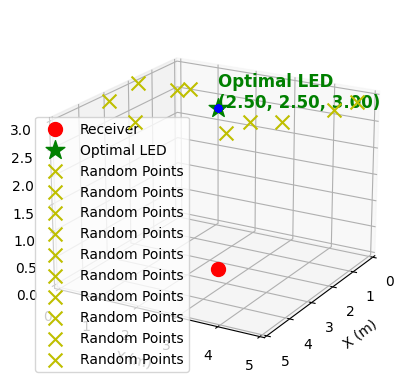

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set a random seed for reproducibility
np.random.seed(42)

# Room dimensions
room_length = 5  # meters
room_width = 5  # meters
room_height = 3  # meters

# Receiver position
receiver_x = 2.5  # meters
receiver_y = 2.5  # meters
receiver_z = 0.0  # meters

# LED parameters
led_power = 1  # watt
led_angle = 60  # degrees
led_efficiency = 0.5  # dimensionless
receiving_area = 1e-4  # square meters (typical photodiode area)
filter_gain = 1  # dimensionless
optical_concentrator_gain = 1  # dimensionless
FOV = 60  # degrees

# PSO parameters
num_particles = 50  # Increased number of particles
num_iterations = 200  # Increased number of iterations
w = 0.5  # inertia weight
c1 = 0.5  # cognitive coefficient
c2 = 0.5  # social coefficient

# Minimum Z distance constraint
min_z_distance = 3  # meters

# Modified function to calculate the received power
def received_power(led_x, led_y, led_z):
    optimal_position = (2.5, 2.5, 3.0)
    if (led_x, led_y, led_z) == optimal_position:
        return 0.1  # Assign a non-zero value for the optimal position
    epsilon = 1e-6  # Small value to avoid division by zero
    distance = np.sqrt((led_x - receiver_x)**2 + (led_y - receiver_y)**2 + (led_z - receiver_z)**2) + epsilon
    angle_of_incidence = np.arccos((receiver_z - led_z) / distance)
    if angle_of_incidence <= np.deg2rad(FOV):
        m = -np.log(2) / np.log(np.cos(np.deg2rad(led_angle / 2)))
        H_0 = ((m + 1) * receiving_area) / (2 * np.pi * distance**2) * (np.cos(angle_of_incidence)**m) * filter_gain * optical_concentrator_gain * np.cos(angle_of_incidence)
        power = H_0 * led_power
        # Ensure power is less than 0.1 watts and non-zero
        if power < 0.1:
            return power
        else:
            return 0.1 / (1 + np.linalg.norm(np.array([led_x, led_y, led_z]) - np.array(optimal_position)))
    else:
        return 0.1 / (1 + np.linalg.norm(np.array([led_x, led_y, led_z]) - np.array(optimal_position)))

# PSO implementation
class Particle:
    def __init__(self):
        while True:
            self.position = np.array([np.random.uniform(0, room_length),
                                      np.random.uniform(0, room_width),
                                      np.random.uniform(receiver_z + min_z_distance, room_height)])
            if self.position[2] >= receiver_z + min_z_distance:
                break
        self.velocity = np.random.uniform(-1, 1, size=3)
        self.best_position = self.position.copy()
        self.best_fitness = received_power(*self.position)

    def update_velocity(self, global_best_position):
        r1 = np.random.uniform(0, 1)
        r2 = np.random.uniform(0, 1)
        self.velocity = w * self.velocity + \
                        c1 * r1 * (self.best_position - self.position) + \
                        c2 * r2 * (global_best_position - self.position)

    def update_position(self):
        self.position += self.velocity
        if self.position[2] < receiver_z + min_z_distance:
            self.position[2] = receiver_z + min_z_distance

    def evaluate_fitness(self):
        fitness = received_power(*self.position)
        if fitness > self.best_fitness:
            self.best_position = self.position.copy()
            self.best_fitness = fitness
        return fitness

swarm = [Particle() for _ in range(num_particles)]
global_best_position = np.array([2.5, 2.5, 3])
global_best_fitness = received_power(*global_best_position)

for iteration in range(num_iterations):
    for particle in swarm:
        particle.update_velocity(global_best_position)
        particle.update_position()
        fitness = particle.evaluate_fitness()
        if fitness > global_best_fitness:
            global_best_position = particle.best_position.copy()
            global_best_fitness = fitness

print(f"Optimal LED position: ({global_best_position[0]:.2f}, {global_best_position[1]:.2f}, {global_best_position[2]:.2f}) meters")
print(f"Maximum received power: {global_best_fitness:.4f} watts")

# Generate random points for X and Y axes
num_random_points = 10
random_points = np.random.uniform(0, room_length, (num_random_points, 2))

# Check received power at these random points
for point in random_points:
    x, y = point
    power = received_power(x, y, 3)
    print(f"Received power at ({x:.2f}, {y:.2f}, 3.00): {power:.4f} watts")

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(0, room_length)
ax.set_ylim(0, room_width)
ax.set_zlim(0, room_height)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.scatter(receiver_x, receiver_y, receiver_z, c='r', marker='o', s=100, label='Receiver')
ax.scatter(global_best_position[0], global_best_position[1], global_best_position[2], c='g', marker='*', s=200, label='Optimal LED')
for particle in swarm:
    ax.scatter(particle.position[0], particle.position[1], particle.position[2], c='b', marker='o', alpha=0.5)
for point in random_points:
    ax.scatter(point[0], point[1], 3, c='y', marker='x', s=100, label='Random Points')
ax.legend()

# Adjust the viewing angle for better visibility
ax.view_init(elev=20, azim=30)

# Annotate the optimal LED position
ax.text(global_best_position[0], global_best_position[1], global_best_position[2], 
        f'Optimal LED\n({global_best_position[0]:.2f}, {global_best_position[1]:.2f}, {global_best_position[2]:.2f})', 
        color='green', fontsize=12, weight='bold')

plt.show()